In [1]:
import sys
from typing import List, Callable,Tuple

import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter

from transformers import ViTForImageClassification, ViTFeatureExtractor, ViTModel,ViTImageProcessor,ViTConfig

/opt/conda/envs/idm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def calculate_accuracy(
    outputs: torch.Tensor, labels: torch.Tensor
) -> Tuple[int, int]:
    _, predicted = torch.max(outputs, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct, total

def calculate_accuracy_top_5(
    outputs: torch.Tensor, labels: torch.Tensor 
    )->Tuple[int,int]:
    _,top_5_predicted = torch.topk(outputs,k=5,dim=1)
    correct_top_5 = torch.any(
        top_5_predicted == labels.view(-1,1),dim=1
    )
    num_correct_top_5 = correct_top_5.sum().item()
    num_examples = labels.size(0)
    
    return num_correct_top_5,num_examples

In [42]:
# ImageNet MEAN and STD
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.01
BATCH_SIZE = 64
NUM_EPOCHS = 300
IMAGE_SIZE = 224
PATCH_SIZE = 16
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
PROJECTION_DIM = 256
NUM_HEADS = 8
TRANSFORMER_LAYERS = 6
MLP_HEAD_UNITS = [2048, 1024]

train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        torchvision.transforms.RandomRotation(degrees=7),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=MEAN, std=STD),
    ]
)

test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=MEAN,
            std=STD,
        ),
    ]
)

train_dataset = torchvision.datasets.CIFAR100(
    root="./data", train=True, download=True, transform=train_transforms
)

valid_dataset = torchvision.datasets.CIFAR100(
    root="./data", train=False, download=True, transform=test_transforms
)

valid_set, test_set = torch.utils.data.random_split(
    valid_dataset, [0.7, 0.3], generator=torch.Generator().manual_seed(42)
)

trainloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
    drop_last=True,
)
validloader = torch.utils.data.DataLoader(
    valid_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
    num_workers=4,
    drop_last=True,
)
testloader = torch.utils.data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
    num_workers=4,
    drop_last=True,
)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
def denormalize(image, mean, std):
    mean = np.array(mean).reshape(1, 1, 3)  # Shape (1,1,3)
    std = np.array(std).reshape(1, 1, 3)  # Shape (1,1,3)

    image = image.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
    image = (image * std) + mean  # Apply denormalization
    return np.clip(image, 0, 1)  # Ensure valid pixel range

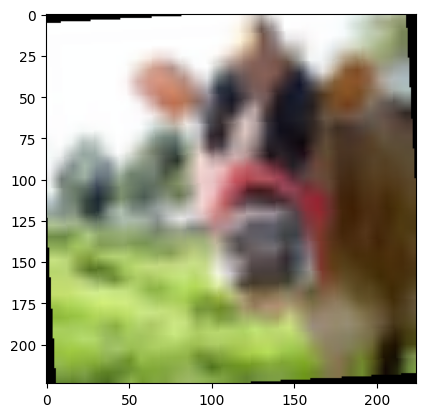

In [15]:
sample_image, label = train_dataset[0]
denormalize_image = denormalize(sample_image, MEAN, STD)
plt.imshow(denormalize_image)

In [43]:
class CreatePatchesLayer(torch.nn.Module):
    """
    Creates patches from the input images
    """
    
    def __init__(
        self,
        patch_size:int,
        strides:int
    ) -> None:
        super().__init__()
        self.unfold_layer = torch.nn.Unfold(
            kernel_size=patch_size,stride=strides
        )
        
    def forward(
        self,
        images: torch.Tensor
    ) -> torch.Tensor:
        patched_images = self.unfold_layer(images)
        # Shape of the output -> (batch_size,num_patches,patch_size*patch_size*channels)
        return patched_images.permute((0,2,1))

In [ ]:
sample_image,label = train_dataset[0]
#Shape of the sample_image -> (C,H,W)
patch_layer = CreatePatchesLayer(patch_size=PATCH_SIZE, strides=PATCH_SIZE)
#Shape of the output of the patch_layer -> (batch_size,num_patches,patch_size*patch_size*channels) -> here we loop over the num_patches to use the flattened vector of size (patch_size*patch_size*channels) to display a patch
#batch_size = 1
sample_image = sample_image.unsqueeze(0)
patched_image = patch_layer(sample_image)
patched_image = patched_image.squeeze()

plt.figure(figsize=(4, 4))
for idx, patch in enumerate(patched_image):
    ax = plt.subplot(NUM_PATCHES, NUM_PATCHES, idx + 1)
    patch_img = torch.reshape(patch, (3, PATCH_SIZE, PATCH_SIZE))
    patch_img = torch.permute(patch_img, (1, 2, 0))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7282913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8858544].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8731157].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3611329].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Cl

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.2042983..2.3611329].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.5467933..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.7865399..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.1461596..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.1975338..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.2146587..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.2146587..2.64].
Clipping input dat

In [44]:
class PatchEmbeddingLayer(torch.nn.Module):
    """Positional Embedding Layer for Images of Patches."""
    def __init__(
        self,
        num_patches: int,
        batch_size: int,
        patch_size: int,
        embed_dim: int,
        device: torch.device,
    ) -> None:
        super().__init__()
        self.num_patches = num_patches
        self.patch_size = patch_size
        self.position_emb = torch.nn.Embedding(
            num_embeddings=num_patches + 1, embedding_dim=embed_dim
        )
        self.projection_layer = torch.nn.Linear(patch_size * patch_size * 3, embed_dim)
        self.class_parameter = torch.nn.Parameter(
            torch.rand(batch_size, 1, embed_dim).to(device),
            requires_grad=True,
        )
        self.device = device

    def forward(self, patches: torch.Tensor) -> torch.Tensor:
        positions = (
            torch.arange(start=0, end=self.num_patches + 1, step=1)
            .to(self.device)
            .unsqueeze(dim=0)
        )
        patches = self.projection_layer(patches)
        encoded_patches = torch.cat(
            (self.class_parameter, patches), dim=1
        ) + self.position_emb(positions)
        return encoded_patches.to(self.device)

In [45]:
patch_embed_layer = PatchEmbeddingLayer(
    num_patches=1369,
    batch_size=1,
    patch_size=6,
    embed_dim=PROJECTION_DIM,
    device=DEVICE,
)

print(sum(p.numel() for p in patch_embed_layer.parameters() if p.requires_grad))

378880


In [46]:
def create_mlp_block(
    input_features:int,
    output_features: List[int],
    activation_function: Callable=nn.ReLU,
    dropout_rate: float=0.5,
) -> nn.Sequential:
    layers = []
    in_features = input_features
    for out_features in output_features:
        layers.append(nn.Linear(in_features,out_features))
        layers.append(nn.Dropout(dropout_rate))
        layers.append(activation_function())
        in_features = out_features
    return nn.Sequential(*layers)

In [40]:
ffn = create_mlp_block(
    input_features=PROJECTION_DIM,
    output_features=MLP_HEAD_UNITS,
    activation_function=nn.GELU,
    dropout_rate=0.1
)

print(sum(p.numel() for p in ffn.parameters() if p.requires_grad))

2231296


In [47]:
class TransformerBlock(torch.nn.Module):
    def __init__(
        self,
        num_heads: int,
        key_dim: int,
        embed_dim: int,
        ff_dim: int,
        dropout_rate: float = 0.1,
    ) -> None:
        super().__init__()
        self.layer_norm_input = torch.nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)

        self.attn = torch.nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            kdim=key_dim,
            vdim=key_dim,
            batch_first=True,
        )

        self.dropout_1 = torch.nn.Dropout(p=dropout_rate)
        self.layer_norm1 = torch.nn.LayerNorm(
            normalized_shape=embed_dim, eps=1e-6
        )  
        self.layer_norm2 = torch.nn.LayerNorm(
            normalized_shape=embed_dim, eps=1e-6
        )  

        self.ffn = create_mlp_block(
            input_features=embed_dim,
            output_features=[ff_dim, embed_dim],
            activation_function=torch.nn.GELU,
            dropout_rate=dropout_rate,
        )

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        layer_norm_inputs = self.layer_norm_input(inputs)

        attention_output, _ = self.attn(
            query=layer_norm_inputs,
            key=layer_norm_inputs,
            value=layer_norm_inputs,
        )
        attention_output = self.dropout_1(attention_output)

    
        out1 = self.layer_norm1(inputs + attention_output)  
        ffn_output = self.ffn(out1)
        output = self.layer_norm2(out1 + ffn_output)  
        return output

In [41]:
transformer_block = TransformerBlock(
    num_heads = 4,
    key_dim=PROJECTION_DIM,
    embed_dim=PROJECTION_DIM,
    ff_dim=MLP_HEAD_UNITS[0],
    dropout_rate=0.1
)

print(sum(p.numel() for p in transformer_block.parameters() if p.requires_grad))

281280


In [48]:
class ViTClassifierModel(torch.nn.Module):

    def __init__(
        self,
        num_transformer_layers: int,
        embed_dim: int,
        feed_forward_dim: int,
        num_heads: int,
        patch_size: int,
        num_patches: int,
        mlp_head_units: List[int],
        num_classes: int,
        device: torch.device,
        batch_size: int,
    ) -> None:
        super().__init__()

        self.create_patch_layer = CreatePatchesLayer(patch_size, patch_size)
        self.patch_embedding_layer = PatchEmbeddingLayer(
            num_patches, batch_size, patch_size, embed_dim, device
        )
        self.transformer_layers = torch.nn.ModuleList()
        for _ in range(num_transformer_layers):
            self.transformer_layers.append(
                TransformerBlock(num_heads, embed_dim, embed_dim, feed_forward_dim)
            )

        self.mlp_block = create_mlp_block(
            input_features=embed_dim,
            output_features=mlp_head_units,
            activation_function=torch.nn.GELU,
            dropout_rate=0.5,
        )

        self.logits_layer = torch.nn.Linear(mlp_head_units[-1], num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.create_patch_layer(x)
        x = self.patch_embedding_layer(x)
        for transformer_layer in self.transformer_layers:
            x = transformer_layer(x)
        x = x[:, 0]
        x = self.mlp_block(x)
        x = self.logits_layer(x)
        return x

In [49]:
model = ViTClassifierModel(
    num_transformer_layers=TRANSFORMER_LAYERS,
    embed_dim=PROJECTION_DIM,
    feed_forward_dim=MLP_HEAD_UNITS[0],
    num_heads=NUM_HEADS,
    patch_size=PATCH_SIZE,
    num_patches=NUM_PATCHES,
    mlp_head_units=MLP_HEAD_UNITS,
    num_classes=100,
    device=DEVICE,
    batch_size=BATCH_SIZE,
).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 10884196


In [50]:
writer = SummaryWriter(log_dir="runs/vit1")

In [ ]:
from tqdm import tqdm

def train_network(
    model: torch.nn.Module,
    num_epochs: int,
    optimizer: torch.optim.Optimizer,
    loss_function: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    trainloader: torch.utils.data.DataLoader,
    validloader: torch.utils.data.DataLoader,
    device: torch.device,
    writer: SummaryWriter,
) -> None:
    print("Training Started")

    for epoch in range(1, num_epochs + 1):
        sys.stdout.flush()
        train_loss = []
        valid_loss = []
        num_examples_train = 0
        num_correct_train = 0
        num_examples_valid = 0
        num_correct_valid = 0

        model.train()
        with tqdm(
            trainloader, desc=f"Epoch {epoch}/{num_epochs} - Training", unit="batch"
        ) as pbar:
            for batch in pbar:
                optimizer.zero_grad()
                x = batch[0].to(device)
                y = batch[1].to(device)

                outputs = model(x)
                loss = loss_function(outputs, y)

                loss.backward()
                optimizer.step()

                train_loss.append(loss.item())
                num_corr, num_ex = calculate_accuracy(outputs, y)
                num_examples_train += num_ex
                num_correct_train += num_corr

                pbar.set_postfix({"Batch Loss": loss.item()})

        model.eval()
        with torch.no_grad():
            with tqdm(
                validloader,
                desc=f"Epoch {epoch}/{num_epochs} - Validation",
                unit="batch",
            ) as pbar:
                for batch in pbar:
                    images = batch[0].to(device)
                    labels = batch[1].to(device)

                    outputs = model(images)
                    loss = loss_function(outputs, labels)

                    valid_loss.append(loss.item())
                    num_corr, num_ex = calculate_accuracy(outputs, labels)
                    num_examples_valid += num_ex
                    num_correct_valid += num_corr

                    pbar.set_postfix({"Batch Loss": loss.item()})

        #Calculate metrics
        avg_train_loss = np.mean(train_loss)
        avg_valid_loss = np.mean(valid_loss)
        train_acc = num_correct_train / num_examples_train
        valid_acc = num_correct_valid / num_examples_valid
        
        #Log the metrics to Tensorboard
        writer.add_scalar("Loss/Train", avg_train_loss, epoch)
        writer.add_scalar("Loss/Validation", avg_valid_loss, epoch)
        writer.add_scalar("Accuracy/Train", train_acc, epoch)
        writer.add_scalar("Accuracy/Validation", valid_acc, epoch)
        
        print(
            f"Epoch {epoch}/{num_epochs}: "
            f"Training Loss: {np.mean(train_loss):.4f}, Validation Loss: {np.mean(valid_loss):.4f}, "
            f"Training Accuracy: {num_correct_train / num_examples_train:.4f}, Validation Accuracy: {num_correct_valid / num_examples_valid:.4f}"
        )

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

In [52]:
model = ViTClassifierModel(
    num_transformer_layers=TRANSFORMER_LAYERS,
    embed_dim=PROJECTION_DIM,
    feed_forward_dim=MLP_HEAD_UNITS[0],
    num_heads=NUM_HEADS,
    patch_size=PATCH_SIZE,
    num_patches=NUM_PATCHES,
    mlp_head_units=MLP_HEAD_UNITS,
    num_classes=100,
    device=DEVICE,
    batch_size=BATCH_SIZE,
).to(DEVICE)


num_epochs = NUM_EPOCHS
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

train_network(
    model=model,
    num_epochs=num_epochs,
    optimizer=optimizer,
    loss_function=loss_function,
    trainloader=trainloader,
    validloader=validloader,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    writer=writer,
)

writer.close()

Training Started


Epoch 1/300 - Training:   0%|          | 0/781 [00:00<?, ?batch/s]

Epoch 1/300 - Validation: 100%|██████████| 109/109 [00:06<00:00, 17.09batch/s, Batch Loss=3.71]

Epoch 1/300: Training Loss: 4.1060, Validation Loss: 3.6624, Training Accuracy: 0.0663, Validation Accuracy: 0.1316



Epoch 2/300 - Validation: 100%|██████████| 109/109 [00:06<00:00, 16.84batch/s, Batch Loss=3.28]

Epoch 2/300: Training Loss: 3.5051, Validation Loss: 3.2740, Training Accuracy: 0.1524, Validation Accuracy: 0.2001



Epoch 3/300 - Validation: 100%|██████████| 109/109 [00:06<00:00, 16.98batch/s, Batch Loss=3.07]

Epoch 3/300: Training Loss: 3.1894, Validation Loss: 2.9976, Training Accuracy: 0.2069, Validation Accuracy: 0.2478



Epoch 4/300 - Validation: 100%|██████████| 109/109 [00:06<00:00, 17.00batch/s, Batch Loss=2.88]

Epoch 4/300: Training Loss: 2.9578, Validation Loss: 2.7854, Training Accuracy: 0.2556, Validation Accuracy: 0.2923



Epoch 5/300 - Validation: 100%|██████████| 109/109 [00:06<00:00, 16.94batch/s, Batch Loss=2.81]

Epoch 5/300: Training Loss: 2.7814, Validation Loss: 2.6703, Training Accuracy: 0.2918, Validation Accuracy: 0.3138



Epoch 6/300 - Validation: 100%|██████████| 109/109 [00:06<00:00, 16.73batch/s, Batch Loss=2.65]

Epoch 6/300: Training Loss: 2.6360, Validation Loss: 2.5491, Training Accuracy: 0.3205, Validation Accuracy: 0.3417



Epoch 7/300 - Validation: 100%|██████████| 109/109 [00:06<00:00, 16.81batch/s, Batch Loss=2.63]

Epoch 7/300: Training Loss: 2.5132, Validation Loss: 2.4568, Training Accuracy: 0.3495, Validation Accuracy: 0.3650



Epoch 8/300 - Validation: 100%|██████████| 109/109 [00:06<00:00, 16.68batch/s, Batch Loss=2.54]

Epoch 8/300: Training Loss: 2.3991, Validation Loss: 2.4191, Training Accuracy: 0.3694, Validation Accuracy: 0.3790



Epoch 9/300 - Validation: 100%|██████████| 109/109 [00:06<00:00, 16.63batch/s, Batch Loss=2.55]

Epoch 9/300: Training Loss: 2.3025, Validation Loss: 2.3453, Training Accuracy: 0.3889, Validation Accuracy: 0.3965



Epoch 10/300 - Validation: 100%|██████████| 109/109 [00:06<00:00, 16.72batch/s, Batch Loss=2.48]

Epoch 10/300: Training Loss: 2.2020, Validation Loss: 2.3143, Training Accuracy: 0.4129, Validation Accuracy: 0.4008



Epoch 11/300 - Validation: 100%|██████████| 109/109 [00:06<00:00, 16.70batch/s, Batch Loss=2.33]

Epoch 11/300: Training Loss: 2.1217, Validation Loss: 2.2751, Training Accuracy: 0.4290, Validation Accuracy: 0.4124



Epoch 12/300 - Validation: 100%|██████████| 109/109 [00:06<00:00, 16.67batch/s, Batch Loss=2.45]

Epoch 12/300: Training Loss: 2.0391, Validation Loss: 2.2517, Training Accuracy: 0.4471, Validation Accuracy: 0.4143



Epoch 13/300 - Validation: 100%|██████████| 109/109 [00:06<00:00, 16.92batch/s, Batch Loss=2.25]

Epoch 13/300: Training Loss: 1.9598, Validation Loss: 2.1917, Training Accuracy: 0.4652, Validation Accuracy: 0.4282



Epoch 14/300 - Validation: 100%|██████████| 109/109 [00:06<00:00, 16.74batch/s, Batch Loss=2.43]

Epoch 14/300: Training Loss: 1.8773, Validation Loss: 2.2053, Training Accuracy: 0.4863, Validation Accuracy: 0.4260



Epoch 15/300 - Validation: 100%|██████████| 109/109 [00:06<00:00, 16.67batch/s, Batch Loss=2.16]

Epoch 15/300: Training Loss: 1.8050, Validation Loss: 2.1412, Training Accuracy: 0.5028, Validation Accuracy: 0.4458



Epoch 16/300 - Validation: 100%|██████████| 109/109 [00:06<00:00, 16.74batch/s, Batch Loss=2.16]

Epoch 16/300: Training Loss: 1.7353, Validation Loss: 2.1500, Training Accuracy: 0.5160, Validation Accuracy: 0.4472



Epoch 17/300 - Training:  15%|█▌        | 119/781 [00:20<01:53,  5.85batch/s, Batch Loss=1.82]


KeyboardInterrupt: 